# **各時点の気象情報で発電量が予測できるかの検証**

各時点の気象情報の予測を行なってからその予測に基づいて書く時点の発電量を予測するというモデルを組みたい

モデルを組む前に書く時点の気象情報の予測力を検証する

### **必要な関数・モジュール**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [4]:
def drop_nan(X, Y):
    '''
    正解データがnanであるデータの組を削除
    '''
    mask = np.isnan(Y)
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

### **データの準備**

In [5]:
# 10分単位の発電量のデータを取ってくる
output_data = pd.read_csv('data/raw_data/train_kwh.tsv', delimiter = '\t')

# datetimeの行をpd.Timestampのインスタンスに変更
output_data = set_time(output_data, 'datetime')
output_data['datetime'] = output_data['datetime'].map(lambda x : pd.to_datetime(x))
    
output_data.head()

,datetime,SOLA01,SOLA02,SOLA03
0,2012-01-01 00:10:00,0,0.0,NaN
1,2012-01-01 00:20:00,0,0.0,NaN
2,2012-01-01 00:30:00,0,0.0,NaN
3,2012-01-01 00:40:00,0,0.0,NaN
4,2012-01-01 00:50:00,0,0.0,NaN


In [6]:
# 予測する発電所番号を決める
target_place = 1

In [7]:
# アメダスデータの読み込み

if target_place == 1 or target_place == 2:
    # 横浜アメダスのデータを使って予測する, amd_46106
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_46106.tsv', delimiter = '\t')
    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
elif target_place == 3:
    # 甲府アメダスのデータを使って予測する, amd_49142
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_49142.tsv', delimiter = '\t')
    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
else:
    raise ValueError("invalid input target_place_num")
    
amd_data.head()

,datetime,pr,f_pr,max_ws,f_max_ws,ave_wv,f_ave_wv,ave_ws,f_ave_ws,max_tp,f_max_tp,min_tp,f_min_tp,sl,f_sl,sd,f_sd,dsd,f_dsd
0,2012-01-01 00:10:00,0,0,48.0,0,36.0,0,32.0,0,57.0,0,56.0,0,0.0,2,0.0,0,0.0,0
1,2012-01-01 00:20:00,0,0,48.0,0,36.0,0,35.0,0,56.0,0,55.0,0,0.0,2,0.0,0,0.0,0
2,2012-01-01 00:30:00,0,0,49.0,0,36.0,0,32.0,0,56.0,0,55.0,0,0.0,2,0.0,0,0.0,0
3,2012-01-01 00:40:00,0,0,49.0,0,35.0,0,35.0,0,56.0,0,54.0,0,0.0,2,0.0,0,0.0,0
4,2012-01-01 00:50:00,0,0,61.0,0,35.0,0,34.0,0,55.0,0,53.0,0,0.0,2,0.0,0,0.0,0


In [8]:
# 欠損値を一つ前の値で置換
amd_data = amd_data.fillna(method='bfill')

# sd, dsdはnanが多すぎるので使わない
input_data = amd_data[['datetime', 'pr', 'max_ws', 'ave_wv', 'ave_ws', 'max_tp', 'min_tp', 'sl']]

In [9]:
input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
input_data['minute'] = input_data['datetime'].map(lambda x: int(x.minute))
input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
input_data['min_cos'] = input_data['minute'].map(lambda x: np.cos(np.pi * x / 60))
input_data['min_sin'] = input_data['minute'].map(lambda x: np.sin(np.pi * x / 60))
input_data['wv_cos'] = input_data['minute'].map(lambda x: np.cos(np.pi * x / 36))
input_data['wv_sin'] = input_data['minute'].map(lambda x: np.sin(np.pi * x / 36))

input_data.head()

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

,datetime,pr,max_ws,ave_wv,ave_ws,max_tp,min_tp,sl,hour,minute,month,month_cos,month_sin,hour_cos,hour_sin,min_cos,min_sin,wv_cos,wv_sin
0,2012-01-01 00:10:00,0,48.0,36.0,32.0,57.0,56.0,0.0,0,10,1,0.965926,0.258819,1.0,0.0,8.660254e-01,0.500000,0.642788,0.766044
1,2012-01-01 00:20:00,0,48.0,36.0,35.0,56.0,55.0,0.0,0,20,1,0.965926,0.258819,1.0,0.0,5.000000e-01,0.866025,-0.173648,0.984808
2,2012-01-01 00:30:00,0,49.0,36.0,32.0,56.0,55.0,0.0,0,30,1,0.965926,0.258819,1.0,0.0,2.832769e-16,1.000000,-0.866025,0.500000
3,2012-01-01 00:40:00,0,49.0,35.0,35.0,56.0,54.0,0.0,0,40,1,0.965926,0.258819,1.0,0.0,-5.000000e-01,0.866025,-0.939693,-0.342020
4,2012-01-01 00:50:00,0,61.0,35.0,34.0,55.0,53.0,0.0,0,50,1,0.965926,0.258819,1.0,0.0,-8.660254e-01,0.500000,-0.342020,-0.939693


In [10]:
# 詳しく分析するために2012~2014年のデータをつかって2015年のデータを予測するというモデルに変更しました
s_idx = input_data[input_data['datetime'] == pd.to_datetime('2012-01-01 00:10')].index[0]
e_idx = input_data[input_data['datetime'] == pd.to_datetime('2014-12-31 23:50')].index[0]

In [11]:
X_df= input_data[['pr', 'max_ws', 'ave_ws', 'max_tp', 'min_tp', 'sl', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin', 'min_cos', 'min_sin', 'wv_cos', 'wv_sin']]
X = np.array(X_df[s_idx:e_idx+1])

In [12]:
Y = np.array(output_data['SOLA0'+str(target_place)][s_idx:e_idx+1])

In [13]:
# Yの値がNanの組みを除外
X_train, Y_train = drop_nan(X, Y)

In [14]:
s_idx = input_data[input_data['datetime'] == pd.to_datetime('2015-01-01 00:10')].index[0]
e_idx = input_data[input_data['datetime'] == pd.to_datetime('2015-12-31 23:50')].index[0]

In [15]:
X_test = np.array(X_df[s_idx:e_idx+1])
Y_test = np.array(output_data['SOLA0'+str(target_place)][s_idx:e_idx+1])

### **とりあえずチューニングなしで**

In [16]:
# ランダムフォレストリグレッサー
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)
Y_train_pred = rf.predict(X_train)
Y_test_pred = rf.predict(X_test)
print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
print("test_mae : ", np.abs(Y_test_pred - Y_test).mean())

train_mae :  13.5687814831
test_mae :  40.8349283662


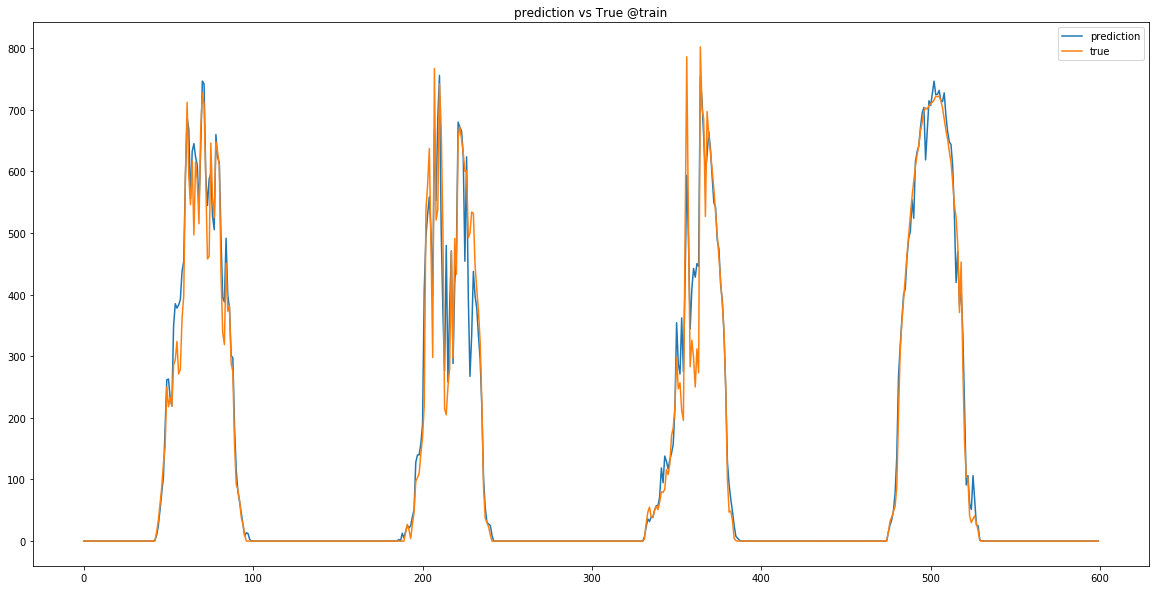

In [17]:
plt.figure(figsize=(20, 10))
plt.plot(Y_train_pred[0:600], label = "prediction")
plt.plot(Y_train[0:600], label = "true")
plt.title("prediction vs True @train")
plt.legend()

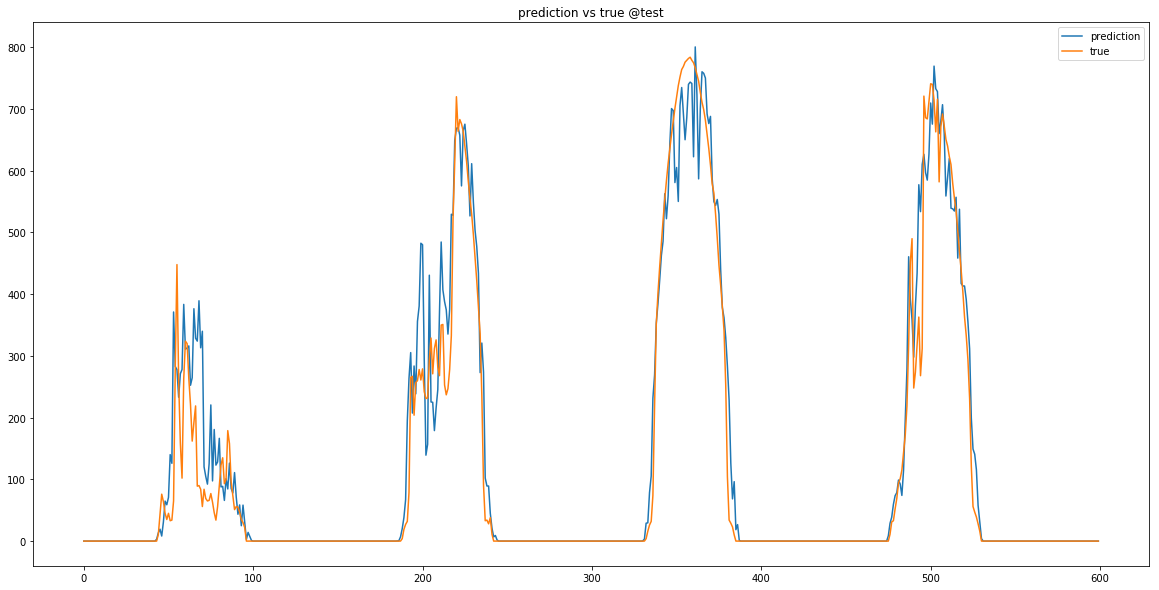

In [18]:
plt.figure(figsize=(20, 10))
plt.plot(Y_test_pred[0:600], label = "prediction")
plt.plot(Y_test[0:600], label = "true")
plt.title("prediction vs true @test")
plt.legend()

In [19]:
important_feature = rf.feature_importances_

In [20]:
features = pd.DataFrame({'feature_name' : X_df.columns,
                         'importance' : rf.feature_importances_})
features.sort_values(by = ['importance'], ascending=False)

,feature_name,importance
5,sl,0.621443
9,hour_sin,0.196925
8,hour_cos,0.054222
7,month_sin,0.035955
3,max_tp,0.022846
1,max_ws,0.016050
4,min_tp,0.015340
2,ave_ws,0.013010
6,month_cos,0.007597
10,min_cos,0.004917


In [21]:
# 30分ごとに集計した場合のmaeを見る
prediction_30 = pd.DataFrame()
prediction_30['datetime'] = input_data['datetime'][s_idx:e_idx+1]
prediction_30['pred'] = Y_test_pred
prediction_30['true'] = Y_test

In [22]:
tmp = prediction_30.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

In [23]:
# 30分ごとに集計した場合のmae
np.abs(np.array(tmp['pred'] - tmp['true'])).mean()

107.182100456621

### **少ないデータで予測することにすると？**

In [24]:
# 詳しく分析するために2012~2014年のデータをつかって2015年のデータを予測するというモデルに変更しました

s_idx = input_data[input_data['datetime'] == pd.to_datetime('2012-01-01 00:10')].index[0]
e_idx = input_data[input_data['datetime'] == pd.to_datetime('2014-12-31 23:50')].index[0]

In [25]:
# features = ['sl', 'month_cos', 'month_sin', 'hour_sin', 'hour_cos', 'min_cos', 'min_sin', 'max_tp', 'max_ws', 'min_tp', 'ave_ws']

features = ['month_cos', 'month_sin', 'hour_sin', 'hour_cos', 'min_cos', 'min_sin', 'max_tp', 'min_tp', 'sl']
X_df= input_data[features]
X_train = np.array(X_df[s_idx:e_idx+1])

In [26]:
Y_train = np.array(output_data['SOLA0'+str(target_place)][s_idx:e_idx+1])

In [27]:
# Yの値がNanの組みを除外
X_train, Y_train = drop_nan(X_train, Y_train)

In [28]:
s_idx = input_data[input_data['datetime'] == pd.to_datetime('2015-01-01 00:10')].index[0]
e_idx = input_data[input_data['datetime'] == pd.to_datetime('2015-12-31 23:50')].index[0]

In [29]:
X_test = np.array(X_df[s_idx:e_idx+1])
Y_test = np.array(output_data['SOLA0'+str(target_place)][s_idx:e_idx+1])

In [30]:
# ランダムフォレストリグレッサー
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)
Y_train_pred = rf.predict(X_train)
Y_test_pred = rf.predict(X_test)
print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
print("test_mae : ", np.abs(Y_test_pred - Y_test).mean())

train_mae :  15.0653980589
test_mae :  42.3636702963


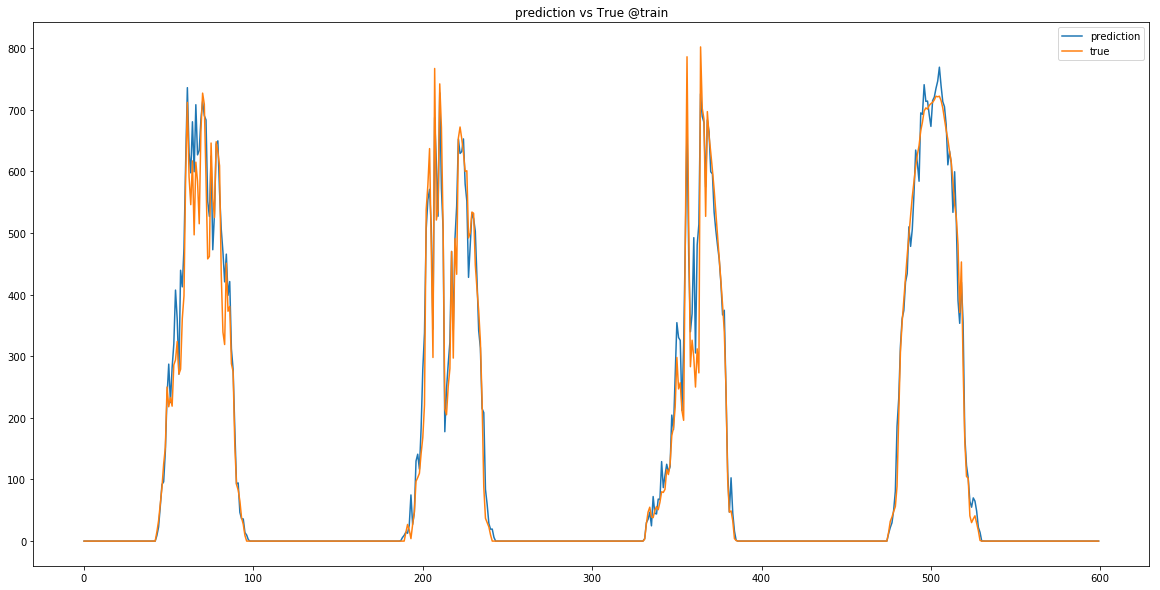

In [31]:
plt.figure(figsize=(20, 10))
plt.plot(Y_train_pred[0:600], label = "prediction")
plt.plot(Y_train[0:600], label = "true")
plt.title("prediction vs True @train")
plt.legend()

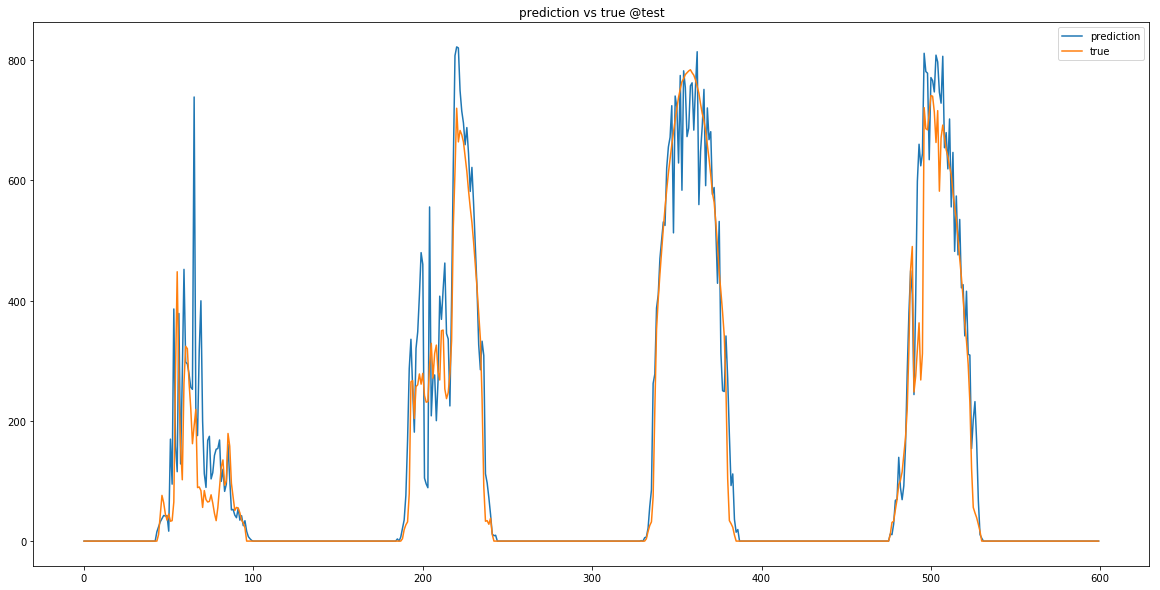

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(Y_test_pred[0:600], label = "prediction")
plt.plot(Y_test[0:600], label = "true")
plt.title("prediction vs true @test")
plt.legend()

In [33]:
# 30分ごとに集計した場合のmaeを見る
prediction_30 = pd.DataFrame()
prediction_30['datetime'] = input_data['datetime'][s_idx:e_idx+1]
prediction_30['pred'] = Y_test_pred
prediction_30['true'] = Y_test

In [34]:
tmp = prediction_30.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

In [35]:
# 30分ごとに集計した場合のmae
np.abs(np.array(tmp['pred'] - tmp['true'])).mean()

110.73738218679784

### **10分ごとをまとめるのではなくて、30分ごとに集計したデータで予測すると？**

In [36]:
# 欠損値を一つ前の値で置換
amd_data = amd_data.fillna(method='bfill')

# sd, dsdはnanが多すぎるので使わない
input_data = amd_data[['datetime', 'pr', 'max_ws', 'ave_wv', 'ave_ws', 'max_tp', 'min_tp', 'sl']]

In [37]:
input_data = input_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

In [38]:
input_data['ave_wv'] = input_data['ave_wv'].map(lambda x : x/3.0)

In [39]:
input_data['datetime'] = input_data.index
input_data.index = np.arange(len(input_data))

In [40]:
input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
input_data['minute'] = input_data['datetime'].map(lambda x: int(x.minute))
input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
input_data['min_cos'] = input_data['minute'].map(lambda x: np.cos(np.pi * x / 60))
input_data['min_sin'] = input_data['minute'].map(lambda x: np.sin(np.pi * x / 60))
input_data['wv_cos'] = input_data['minute'].map(lambda x: np.cos(np.pi * x / 36))
input_data['wv_sin'] = input_data['minute'].map(lambda x: np.sin(np.pi * x / 36))

input_data.head()

,pr,max_ws,ave_wv,ave_ws,max_tp,min_tp,sl,datetime,hour,minute,month,month_cos,month_sin,hour_cos,hour_sin,min_cos,min_sin,wv_cos,wv_sin
0,0,129.0,35.666667,87.0,183.0,180.0,0.0,2012-01-01 00:00:00,0,0,1,0.965926,0.258819,1.000000,0.000000,1.000000e+00,0.0,1.000000,0.0
1,0,159.0,35.333333,101.0,167.0,162.0,0.0,2012-01-01 00:30:00,0,30,1,0.965926,0.258819,1.000000,0.000000,2.832769e-16,1.0,-0.866025,0.5
2,0,158.0,35.333333,91.0,162.0,157.0,0.0,2012-01-01 01:00:00,1,0,1,0.965926,0.258819,0.991445,0.130526,1.000000e+00,0.0,1.000000,0.0
3,0,180.0,35.666667,116.0,153.0,148.0,0.0,2012-01-01 01:30:00,1,30,1,0.965926,0.258819,0.991445,0.130526,2.832769e-16,1.0,-0.866025,0.5
4,0,172.0,35.666667,111.0,140.0,134.0,0.0,2012-01-01 02:00:00,2,0,1,0.965926,0.258819,0.965926,0.258819,1.000000e+00,0.0,1.000000,0.0


In [41]:
output_30 = output_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

In [42]:
output_30['datetime'] = output_30.index
output_30.index = np.arange(len(output_30))

In [43]:
# 詳しく分析するために2012~2014年のデータをつかって2015年のデータを予測するというモデルに変更しました
s_idx = input_data[input_data['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
e_idx = input_data[input_data['datetime'] == pd.to_datetime('2014-12-31 23:30')].index[0]

In [44]:
X_df= input_data[['pr', 'max_ws', 'ave_ws', 'max_tp', 'min_tp', 'sl', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin', 'min_cos', 'min_sin', 'wv_cos', 'wv_sin']]
X = np.array(X_df[s_idx:e_idx+1])

In [45]:
Y = np.array(output_30['SOLA0'+str(target_place)][s_idx:e_idx+1])

In [46]:
# Yの値がNanの組みを除外
X_train, Y_train = drop_nan(X, Y)

In [47]:
s_idx = input_data[input_data['datetime'] == pd.to_datetime('2015-01-01 00:00')].index[0]
e_idx = input_data[input_data['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

In [48]:
X_test = np.array(X_df[s_idx:e_idx+1])
Y_test = np.array(output_30['SOLA0'+str(target_place)][s_idx:e_idx+1])

In [49]:
# ランダムフォレストリグレッサー
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)
Y_train_pred = rf.predict(X_train)
Y_test_pred = rf.predict(X_test)
print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
print("test_mae : ", np.abs(Y_test_pred - Y_test).mean())

train_mae :  38.3516347324
test_mae :  103.223430365


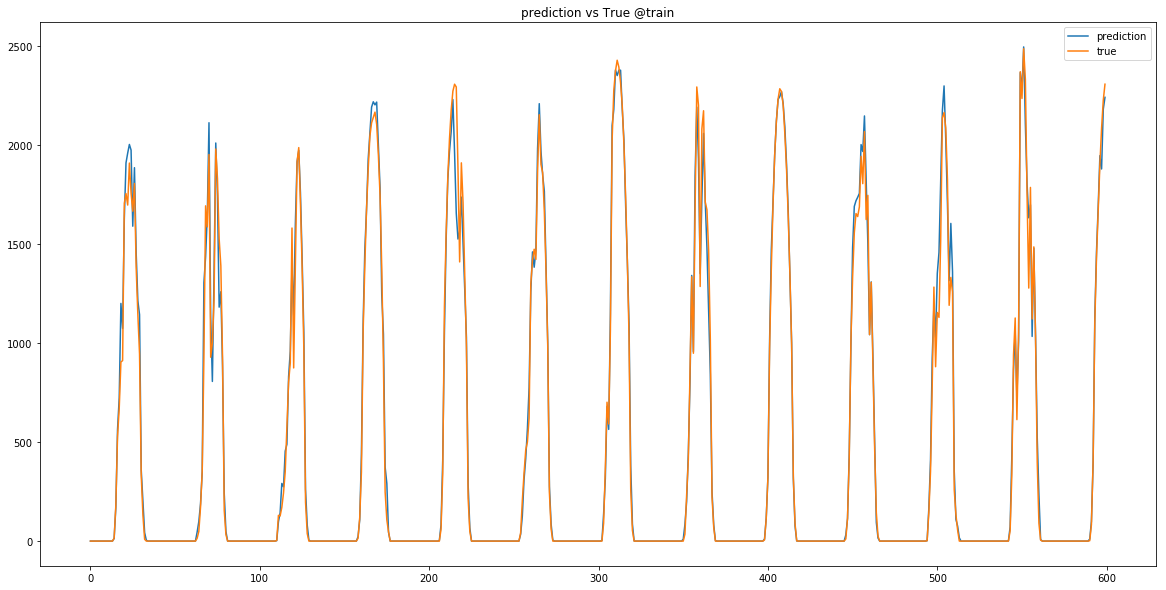

In [50]:
plt.figure(figsize=(20, 10))
plt.plot(Y_train_pred[0:600], label = "prediction")
plt.plot(Y_train[0:600], label = "true")
plt.title("prediction vs True @train")
plt.legend()

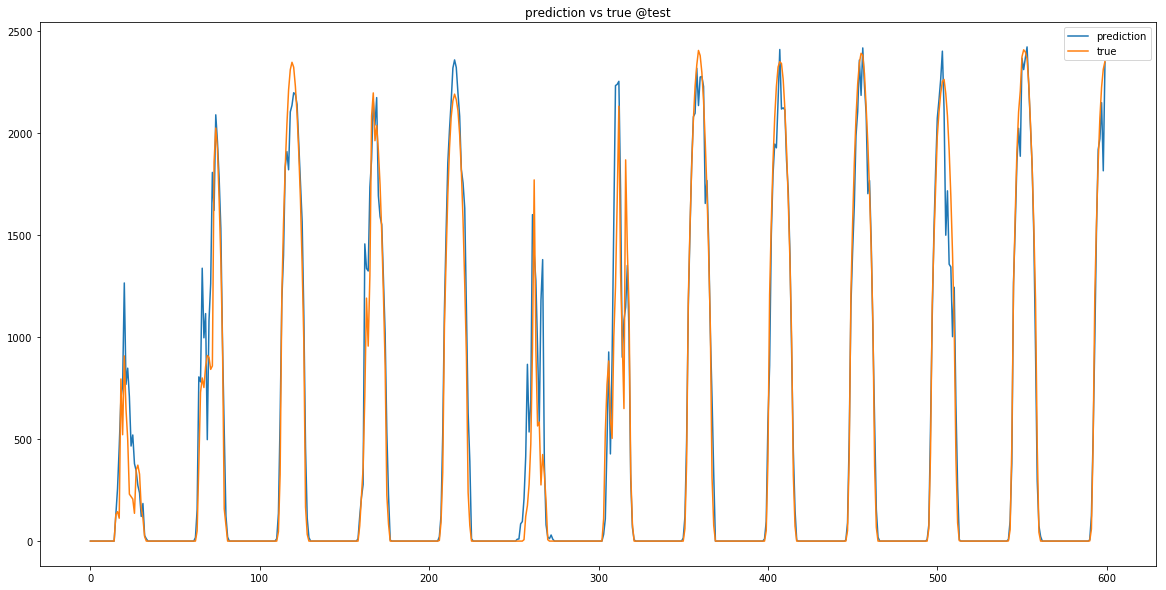

In [51]:
plt.figure(figsize=(20, 10))
plt.plot(Y_test_pred[0:600], label = "prediction")
plt.plot(Y_test[0:600], label = "true")
plt.title("prediction vs true @test")
plt.legend()

### 30分ごとで予測するより10分ごとを集計した方がよい